## Original Reference : [View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb)

Checkout [using Google Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) for additional information about their integration.

The [pytorch cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html) will be useful in this learning process if you need a quick reference.

---
[PyTorch](https://pytorch.org/) is an open-source machine learning framework that allows you to write your own neural networks and optimize them efficiently.
- PyTorch is well established, has a large developer community, and is very flexible and especially used in research.
- PyTorch is not the only framework of this kind. Alternatives to PyTorch include [TensorFlow](https://www.tensorflow.org/), [JAX](https://github.com/google/jax#quickstart-colab-in-the-cloud) and [Caffe](http://caffe.berkeleyvision.org/).
- Once you have a deep knowledge of one machine learning framework, it is very easy to learn other frameworks, as many frameworks share the same concepts and ideas.

In [2]:
# Import PyTorch
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


**Randon Seed**:
PyTorch provides stochastic features, however, a very good practice is to set up your code to be reproducible using exactly the same random numbers.
Let's set the random seeds as shown below.

In [3]:
torch.manual_seed(37) # Setting the seed

### 0.1. Tensors

Tensors are the PyTorch equivalent of Numpy arrays and also support GPU acceleration.
The name "tensor" is a generalization of the concept, for example, vectors are one-dimensional tensors and matrices are two-dimensional tensors.
When working with neural networks, we use tensors of various shapes and number of dimensions.
Numpy arrays are very similar to tensors, so we can convert most tensors to numpy arrays and vice versa.

#### (1) Initialization
First, let's look at the different ways to create tensors.
There are many possible options, and the simplest way is to call `torch.Tensor`, passing the desired shape as an input argument.
The `torch.Tensor` allocates memory for the desired tensor, but reuses any values that have already been in the memory.

In [4]:
x = torch.Tensor(1, 2, 3)
print(x)

tensor([[[4.7582e-20, 4.5118e-41, 4.7582e-20],
         [4.5118e-41, 4.7582e-20, 4.5118e-41]]])


You can get the shape of a tensor in the same way as numpy, `x.shape`, or using the `.size` method.

In [5]:
shape = x.shape # x.size()
print("Shape:", x.shape)

Shape: torch.Size([1, 2, 3])



Alternatively, there are various options to directly assign values to the tensor during initialization:
* `torch.Tensor` (input list): Creates a tensor from the list you provide.
* `torch.zeros`: Creates a tensor filled with zeros.
* `torch.ones`: Creates a tensor filled with ones.
* `torch.rand`: Creates a tensor with random values sampled uniformly between 0 and 1.
* `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1.
* `torch.arange`: Creates a tensor containing the values $N,N+1,N+2,...,M$

In [6]:
# Create a tensor from a (nested) list
x = torch.Tensor([[3., 5., 2.], [7., 1., 9.]])
print(x, "\nShape:", x.shape)

tensor([[3., 5., 2.],
        [7., 1., 9.]]) 
Shape: torch.Size([2, 3])


In [7]:
# Try It Out!
'''
1. Create a tensor filled with the scalar value 1 with the shape [1, 2, 7]
2. Check the shape of the tensor
'''

"""Type Your Answer Here"""

'Type Your Answer Here'

#### Tensor to Numpy, and Numpy to Tensor

In general, tensors can be converted to numpy arrays, and numpy arrays can be converted back to tensors:
- To convert a numpy array to a tensor, we can use the `torch.from_numpy` function.
- To transform a PyTorch tensor back to a numpy array, we can use the `.numpy()` on tensors.

In [8]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)
print("Numpy -> PyTorch tensor:\n", tensor)
np_arr = tensor.numpy()
print("PyTorch -> Numpy array:\n", np_arr)

Numpy -> PyTorch tensor:
 tensor([[1, 2],
        [3, 4]])
PyTorch -> Numpy array:
 [[1 2]
 [3 4]]


Another common operation is to change the shape of a tensor.
A tensor can be re-organized to a different shape with the same number of elements, e.g. a tensor of size (6) or (3,2).
In PyTorch, this operation is called a `view`.

In [9]:
# Create a 1-D tensor of size 6
x = torch.arange(6)
print(x, "\nShape:", x.shape)
x = x.view(3, 2)
print(x, "\nShape:", x.shape)

tensor([0, 1, 2, 3, 4, 5]) 
Shape: torch.Size([6])
tensor([[0, 1],
        [2, 3],
        [4, 5]]) 
Shape: torch.Size([3, 2])


### 0.2. Dynamic Computation Graph and Backpropagation

PyTorch serves as a preferred framework for deep learning projects primarily because it offers automatic differentiation, allowing us to effortlessly obtain **gradients** or **derivatives** of the functions we define.

Imagine we have some data as input $\mathbf{x}$.
As we manipulate our input, Pytorch automatically generates a **computational graph**; this means PyTorch will keep track of the graph for us.
So all we need to do is calculate the **output**.
we can then ask PyTorch to automatically get the **gradient** for us.

> **Note:  Why do we want gradients?** Consider that we have defined a function, a neural net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is, and how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want (sources: [[1]](https://www.kdnuggets.com/2020/05/5-concepts-gradient-descent-cost-function.html), [[2]](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb#scrollTo=Dr4ENWdTHNA-)).

The first thing we need to do is to specify which tensors require gradients.
By default, no gradients are needed when creating a tensor.

In [10]:
x = torch.ones((3,))
print(x.requires_grad)

False


We can change this for an existing tensor using the function `requires_grad_()`.
Alternatively, we can pass the argument `requires_grad=True` when creating a tensor.

In [11]:
x.requires_grad_(True)
print(x.requires_grad)
z = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
print(z)

True
tensor([[ 1., -1.],
        [ 1.,  1.]], requires_grad=True)


To get familiar with the concept of computational graphs, let's create a graph for the following function:

$$y = \frac{1}{n(x)}\sum_i \left[(x_i + 2)^2 + 3\right],$$

where $n(x)$ denotes the number of elements in $x$, i.e., we are taking a mean operation within the sum.
You could imagine that $x$ are our parameters, and we want to optimize (either maximize or minimize) the output $y$.
For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$.

For example, assume our input is $\mathbf{x}=[0,1,2]$:

In [12]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("x = ", x)

x =  tensor([0., 1., 2.], requires_grad=True)


Then let's build the computational graph step by step.
We can combine multiple operations on a single line, but we'll separate them here so that we can better understand how they add to the computation graph.

In [13]:
a = x + 2
print("a =", a)
b = a ** 2
print("b = ", b)
c = b + 3
print("c = ", c)
y = c.mean()
print("y = ", y)

a = tensor([2., 3., 4.], grad_fn=<AddBackward0>)
b =  tensor([ 4.,  9., 16.], grad_fn=<PowBackward0>)
c =  tensor([ 7., 12., 19.], grad_fn=<AddBackward0>)
y =  tensor(12.6667, grad_fn=<MeanBackward0>)


Here, We calculate $a$ based on the input $x$ and the constant $2$.
Next, $b$ is $a$ squared, and so on.

Each node in the computational graph automatically defined a function that computes the gradient with respect to its inputs, `grad_fn`.
Then we can perform backpropagation on the computational graph by calling the `backward()` on the final output.
This function effectively computes the gradient for each tensor that has the property `requires_grad=True`.

In [14]:
y.backward()

In short, `x.grad` now contains the gradient $\partial y/ \partial \mathcal{x}$, which represents how changes in $\mathbf{x}$ affect the output $y$ given the current input $\mathbf{x}=[0,1,2]$:

In [15]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


# PyTorch Computer Vision

Computer vision is the art of teaching a computer to see.

![example computer vision problems](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-computer-vision-problems.png)
*Example computer vision problems for binary classification, multiclass classification, object detection and segmentation.*

## What we're going to cover

![a PyTorch workflow with a computer vision focus](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-pytorch-computer-vision-workflow.png)

## 1. Getting a dataset

`torchvision.datasets` contains a lot of example datasets you can use to practice writing computer vision code on. FashionMNIST is one of those datasets. And since it has 10 different image classes (different types of clothing), it's a multi-class classification problem.

We'll be building a computer vision neural network to identify the different styles of clothing in these images.

In [17]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10095585.00it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 162367.79it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3108543.38it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5791919.79it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 1.1 Input and output shapes of a computer vision model

We've got a big tensor of values (the image) leading to a single value for the target (the label).

Let's see the image shape.

In [18]:
# See first training sample
image, label = train_data[0]
### Exercise : print shape of the image tensor and the label
image.shape, label

(torch.Size([1, 28, 28]), 9)

The shape of the image tensor is:

```
[color_channels=1, height=28, width=28]
```

Having `color_channels=1` means the image is grayscale.

![example input and output shapes of the fashionMNIST problem](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-computer-vision-input-and-output-shapes.png)
*Various problems will have various input and output shapes. But the premise remains: encode data into numbers, build a model to find patterns in those numbers, convert those patterns into something meaningful.*

If `color_channels=3`, the image comes in pixel values for red, green and blue (RGB).

The order of our current tensor is often referred to as `CHW` (Color Channels, Height, Width).

> **Note:** You'll also see `NCHW` and `NHWC` formats where `N` stands for *number of images*. For example if you have a `batch_size=32`, your tensor shape may be `[32, 1, 28, 28]`. We'll cover batch sizes later.

In [19]:
# How many training samples are there?
len(train_data.data)
### Exercise : How many test samples are there?
# len(test_data.data)

60000

In [20]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.2 Visualizing our data

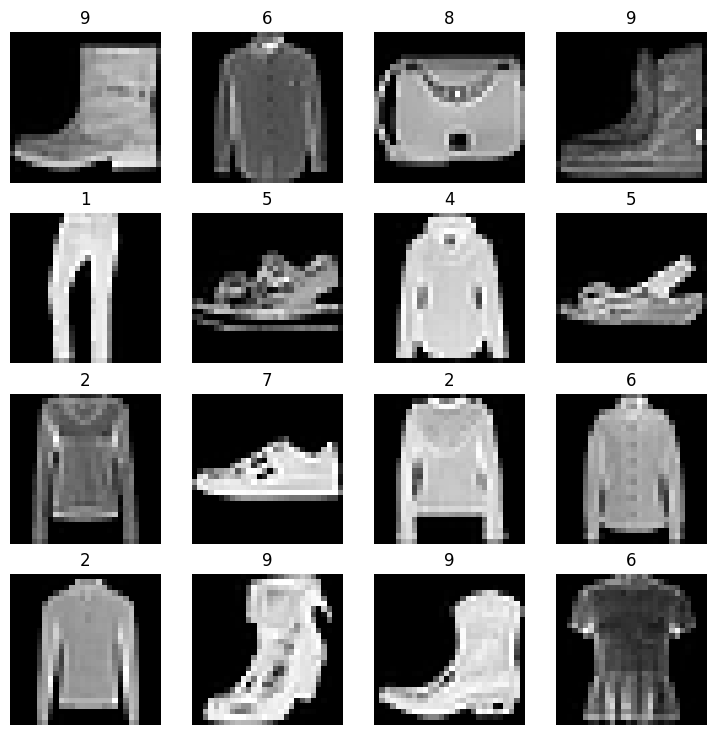

In [21]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label)
    ### Exercise : print the class names instead of the number as the title
    # plt.title(class_names[label])
    plt.axis(False);

## 2. Prepare DataLoader

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.

It turns a large `Dataset` into a Python iterable of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

With **mini-batches** (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

In [22]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")

### Exercise: create test dataloader with same batch size but shuffle=False
test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [23]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. Setup device agnostic-code (for using a GPU if there is one)
Let's setup some [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#best-practices) for our models and data to run on GPU if it's available.

If you're running this notebook on Google Colab, and you don't a GPU turned on yet, turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [24]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 4. Model 1: Build a baseline model

Time to build a **baseline model** by subclassing `nn.Module`.

Our baseline will consist of two [`nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers after the [`nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) layer, along with non-linear functions (`nn.ReLU()`) in between each linear layer.

`nn.Flatten()` compresses the dimensions of a tensor into a single vector. Let's check how it works.

In [25]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
### Exercise : print shape after the forward pass
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


We've now turned our pixel data from height and width dimensions into one long **feature vector** for the `nn.Linear()` layers.

Let's create the neural network model and instantiate it.

In [26]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [27]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [28]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### 4.2 Creating a function to time our experiments

Our timing function will import the [`timeit.default_timer()` function](https://docs.python.org/3/library/timeit.html#timeit.default_timer) from the Python [`timeit` module](https://docs.python.org/3/library/timeit.html).

In [29]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 4.3 Functions for training and test loops

Now create a training loop and a testing loop to train and evaluate our model.

Our data batches are contained within our `DataLoader`s, `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

A batch is `BATCH_SIZE` samples of `X` (features) and `y` (labels), with `BATCH_SIZE=32`.

And we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it

To use device-agnostic code, ensure calling `.to(device)` on feature (`X`) and target (`y`) tensors.

> **Note:** Since these are functions, you can customize them in any way you like.

In [30]:
from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy).
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### And we'll combine train_step() and test_step() into train()

Use these inside another loop for each epoch.

> **Note:** You can customize how often you do a testing step in comparison to the testing steps.

In [32]:
from typing import Dict, List

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
  """
  # Create empty results dictionary
  results = {
      "model_name": model._get_name(),
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Let's leverage the functions we've got above to train and test.

In [33]:
# Set random seeds
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 3

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
total_train_time_model_1 = print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0920 | train_acc: 0.6134 | test_loss: 0.9564 | test_acc: 0.6500
Epoch: 2 | train_loss: 0.7810 | train_acc: 0.7193 | test_loss: 0.7223 | test_acc: 0.7391
Epoch: 3 | train_loss: 0.6703 | train_acc: 0.7594 | test_loss: 0.6850 | test_acc: 0.7502
Train time on cuda: 29.929 seconds


> **Note:** The training time on CUDA vs CPU will depend largely on the quality of the CPU/GPU you're using, and also upon the size of the dataset and the model

## 5. Model 2: Building a Convolutional Neural Network (CNN)

[Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network)s are known for their capabilities to find patterns in visual data.

The CNN model we're going to be using is known as TinyVGG from the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) website.

It follows the typical structure of a convolutional neural network:

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`

Where the contents of `[Convolutional layer -> activation layer -> pooling layer]` can be upscaled and repeated multiple times, depending on requirements.

In [34]:
# Create a convolutional neural network
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = TinyVGG(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 5.1 Stepping through `nn.Conv2d()`

* [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), also known as a 2-dimensional convolutional layer.
* [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), also known as a max pooling layer.

In [35]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


Parameters of `nn.Conv2d()`:
* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution.
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. Default: 0.

![example of going through the different parameters of a Conv2d layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

*Example of what happens when you change the hyperparameters of a `nn.Conv2d()` layer.*

In [36]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image).shape # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

torch.Size([10, 62, 62])

In [37]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [38]:
# Check out the conv_layer internal parameters
print([(key, value.shape) for (key, value) in conv_layer.state_dict().items()])
# [out_channels, in_channels, kernel_size, kernel_size], [out_channels]

[('weight', torch.Size([10, 3, 3, 3])), ('bias', torch.Size([10]))]


### 5.2 Stepping through `nn.MaxPool2d()`

In [39]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


**Every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space**.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being *smaller* in size than the original values.

![each layer of a neural network compresses the original input data into a smaller representation that is (hopefully) capable of making predictions on future input data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv-net-as-compression.png)

The `nn.Conv2d()` performs a convolutional operation on the data (see this in action on the [CNN Explainer webpage](https://poloclub.github.io/cnn-explainer/)).

A `nn.MaxPool2d()` layer: take the maximum value from a portion of a tensor and disregard the rest.

> **Exercise:** What do you think the [`nn.AvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) layer does? Try making a random tensor like we did above and passing it through. Check the input and output shapes as well as the input and output values.

### 5.3 Training and testing `model_2` using our training and test functions

In [40]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 3

# Recreate an instance of TinyVGG
model_2 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

# Start the timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
total_train_time_model_2 = print_train_time(start=start_time,
                                           end=end_time,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5797 | train_acc: 0.7912 | test_loss: 0.3878 | test_acc: 0.8600
Epoch: 2 | train_loss: 0.3561 | train_acc: 0.8719 | test_loss: 0.3602 | test_acc: 0.8639
Epoch: 3 | train_loss: 0.3180 | train_acc: 0.8852 | test_loss: 0.3214 | test_acc: 0.8814
Train time on cuda: 36.116 seconds


## 6. Performance Comparison

We've trained different models.

1. `model_1` - our baseline model with `nn.ReLU()` layers in between the `nn.Linear()` layers.
2. `model_2` - our first CNN model that mimics the TinyVGG architecture on the CNN Explainer website.

Looks like the convolutional and max pooling layers helped improve performance a little.

### 6.1 Plot the loss curves

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_1_results` dictionary.

In [55]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

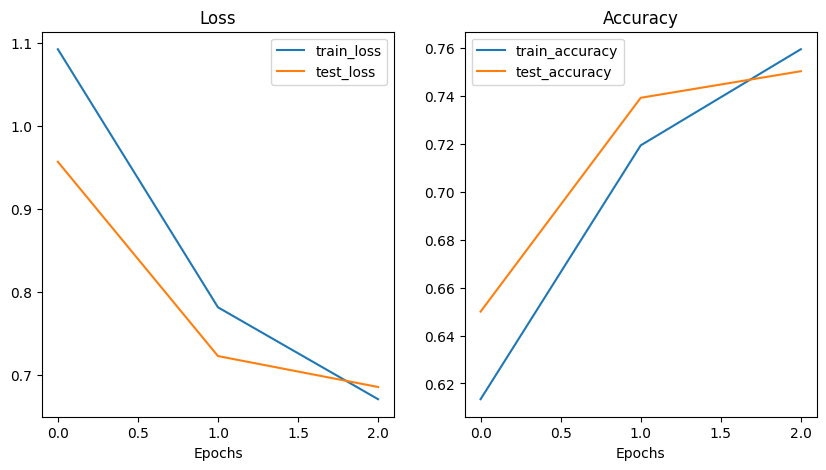

In [56]:
plot_loss_curves(model_1_results)

### 6.2 What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### 6.3 **Exercise** : Plot the loss curves of the VGG model and compare the performance with respect to the baseline

### Performance-speed tradeoff

Generally, you get better performance (lowest loss, highest accuracy) out of a larger, more complex model (like we did with `model_2`).

However, this performance increase often comes at a sacrifice of training speed and inference speed.

> **Note:** The training times you get will be very dependant on the hardware you use.

## 7. Make and evaluate random predictions with best model

In [41]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [42]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [43]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 0, 7, 2, 3, 0, 4, 7, 1]))

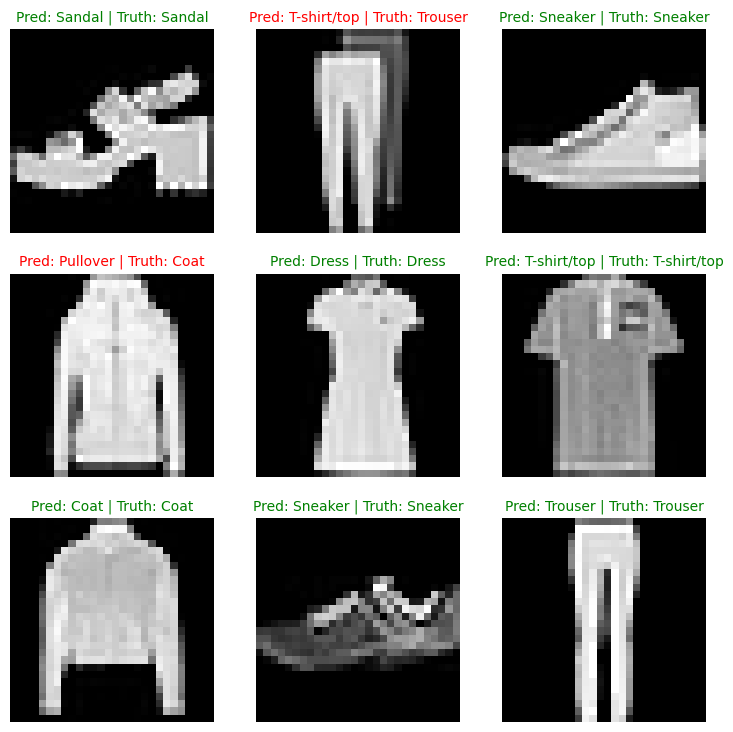

In [44]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 8. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

Let's start by making predictions with our trained model.

In [45]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [46]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import plotly.express as px

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = confusion_matrix(
    y_true=test_data.targets,
    y_pred=y_pred_tensor)

# 3. Plot the confusion matrix
df_cm = pd.DataFrame(
    confmat,
    index = [i for i in class_names],
    columns = [i for i in class_names])
fig = px.imshow(df_cm, text_auto=True)
fig.show()

# Can also use seaborn
# import seaborn as sns
# plt.figure(figsize = (10,8))
# sns.heatmap(df_cm, cmap='coolwarm', annot=True, fmt='d')

We can see our model does fairly well since most of the data is on the diagonal.

The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt". It's understandable the model sometimes predicts "Shirt" for images labelled "T-shirt/top".

This kind of information is often more helpful than a single accuracy metric because it tells use *where* a model is getting things wrong. It also hints at *why* the model may be getting certain things wrong.

We can use this kind of information to further inspect our models and data to see how it could be improved.

> **Exercise:** Use the trained `model_2` to make predictions on the test FashionMNIST dataset. Then plot some predictions where the model was wrong alongside what the label of the image should've been. After visualing these predictions do you think it's more of a modelling error or a data error? As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

## 9. Save and load best performing model

We can save and load a PyTorch model using a combination of:
* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [47]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


Now we've got a saved model `state_dict()` we can load it back in using a combination of `load_state_dict()` and `torch.load()`.

Since we're using `load_state_dict()`, we'll need to create a new instance of `TinyVGG()` with the same input parameters as our saved model `state_dict()`.

In [48]:
# Create a new instance of TinyVGG (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = TinyVGG(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

And now we've got a loaded model we can evaluate it with `eval_model()` to make sure its parameters work similarly to `model_2` prior to saving.

In [49]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = test_step(model=loaded_model_2,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)

In [50]:
# Check to see if this result is close to the final value of the original version
np.isclose(model_2_results["test_loss"][-1], loaded_model_2_results[0],
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

True

# Exercises

**Resources:**
* [Excellent place to learn pytorch](https://www.learnpytorch.io/)
* [Official deep learning blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [3B1B videos](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)


**Exercises:**
* [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* Watch [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.
* Spend 10-minutes clicking thorugh the different options of the [PyTorch vision library](https://pytorch.org/vision/stable/index.html), what different modules are available?
* For a large number of pretrained PyTorch computer vision models as well as many different extensions to PyTorch's computer vision functionalities check out the [PyTorch Image Models library `timm`](https://github.com/rwightman/pytorch-image-models/) (Torch Image Models) by Ross Wightman.